In [41]:
## PyTorch
import torch

## Torchvision 
from torchvision import transforms
import torchvision.models as models

from torchsummary import summary


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(42) # Setting the seed

# GPU operations have a separate seed we also want to set
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda


Question 1.1

In [ ]:
# Reference : https://huggingface.co/spaces/pytorch/vgg-nets/blame/main/app.py

def inference(input_image):
## All models in question 1.1 use the same image transformation
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Step 1: Preprocess
    input_tensor = transformation(input_image)


    # Step 2 create a mini-batch as expected by the model
    input_batch = input_tensor.unsqueeze(0) 
   

    with torch.no_grad():
        output = model(input_batch)

    return output



In [ ]:

model_list = ['vgg11','vgg11_bn','resnet18','resnet34','densenet121','mobilenet_v3_small']

avg_time = []
torch.cuda.empty_cache()

for model_name in model_list:
  time = 0
  model = getattr(models, model_name)
  model = model(pretrained=True).to(device)
  model.eval()


  for i in range(30):
    image_input = torch.rand(3,256,256)
    image_input = image_input.to(device)
    output = inference(image_input)  #operation to 'burn in' GPU


  start = torch.cuda.Event(enable_timing=True)
  end = torch.cuda.Event(enable_timing=True)
  
  for i in range(40):
    image_input = torch.rand(3,256,256)
    image_input = image_input.to(device)
    start.record()
    output = inference(image_input)
    end.record()
    torch.cuda.synchronize()  # Waits for everything to finish running on the GPU
    #print(f"Average GPU time for {model_name}: {start.elapsed_time(end):6.5f}ms")  # Milliseconds
    time+=start.elapsed_time(end)
  print(f"Average GPU time for {model_name}: {time/40:6.5f}ms")  # Milliseconds
  avg_time.append(time/40)
  torch.cuda.empty_cache()



Average GPU time for vgg11: 6.96183ms
Average GPU time for vgg11_bn: 7.23328ms
Average GPU time for resnet18: 4.79752ms
Average GPU time for resnet34: 8.37802ms
Average GPU time for densenet121: 20.98912ms
Average GPU time for mobilenet_v3_small: 7.23479ms


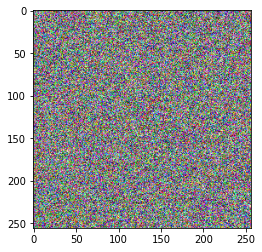

In [ ]:
import matplotlib.pyplot as plt
tensor_image = torch.rand(3,256,256)
plt.imshow(tensor_image.permute(1, 2, 0))

In [ ]:
print(avg_time)

[6.961833560466767, 7.233279204368591, 4.797520792484283, 8.378023982048035, 20.989122200012208, 7.2347943663597105]


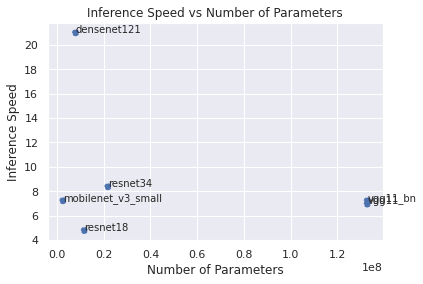

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

# Part 1 : get number of parameters and top1 accuracy : pytorch
top1_accuracy = [69.02,70.37,	69.758,73.314,74.434,67.668]
num_parameters = [132863336,132868840,11689512,21797672,7978856,2542856]


plt.scatter(num_parameters,avg_time,linestyle='--', marker='o')
sn.set(font_scale=1)
plt.xlabel("Number of Parameters")
plt.ylabel("Inference Speed")
plt.title(f"Inference Speed vs Number of Parameters")

for i in range(6):
  plt.annotate(model_list[i], (num_parameters[i],avg_time[i]),fontsize=10)
  
plt.show()
plt.close()

<Figure size 720x720 with 0 Axes>

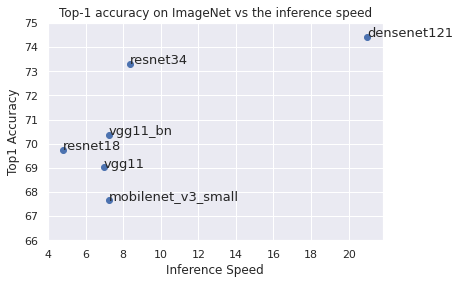

<Figure size 720x720 with 0 Axes>

In [ ]:
import numpy as np
import seaborn as sn

plt.scatter(avg_time,top1_accuracy, marker='o')
sn.set(font_scale=1)
plt.xlabel("Inference Speed")
plt.ylabel("Top1 Accuracy")
plt.title(f"Top-1 accuracy on ImageNet vs the inference speed")

for i in range(6):
  plt.annotate(model_list[i], (avg_time[i], top1_accuracy[i]),fontsize=13)

plt.yticks(np.arange(66,76))

plt.figure(figsize=(10,10))

They don't scale proportionately. It depends on the architecture as well. But we do see a pattern.




In [ ]:
import torchvision.models as models

model = models.vgg11(pretrained=True)

sum(p.numel() for p in model.parameters())


132863336

Question 1.2

Without torch.no_grad()

In [ ]:
# Reference : https://huggingface.co/spaces/pytorch/vgg-nets/blame/main/app.py

def inference(input_image):
## All models in question 1.1 use the same image transformation
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Step 1: Preprocess
    input_tensor = transformation(input_image)
    #print(input_tensor.shape)

    # Step 2 create a mini-batch as expected by the model
    input_batch = input_tensor.unsqueeze(0) 
    #print(input_batch.shape)

    
    output = model(input_batch)

    return output



model_list = ['vgg11','vgg11_bn','resnet18','resnet34','densenet121','mobilenet_v3_small']


avg_time_with_grads = []
torch.cuda.empty_cache()

for model_name in model_list:
  time = 0
  model = getattr(models, model_name)
  model = model(pretrained=True).to(device)
  image_input = image_input.to(device)
  model.eval()


  for i in range(30):
    image_input = torch.rand(3,256,256)
    image_input = image_input.to(device)
    output = inference(image_input)  #operation to 'burn in' GPU


  start = torch.cuda.Event(enable_timing=True)
  end = torch.cuda.Event(enable_timing=True)
  
  for i in range(40):
    image_input = torch.rand(3,256,256)
    image_input = image_input.to(device)
    start.record()
    output = inference(image_input)
    end.record()
    torch.cuda.synchronize()  # Waits for everything to finish running on the GPU
    #print(f"Average GPU time for {model_name}: {start.elapsed_time(end):6.5f}ms")  # Milliseconds
    time+=start.elapsed_time(end)
  print(f"Average GPU time for {model_name}: {time/40:6.5f}ms")  # Milliseconds
  avg_time_with_grads.append(time/40)
  torch.cuda.empty_cache()




/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Average GPU time for vgg11: 7.09278ms


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Average GPU time for vgg11_bn: 7.31474ms


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Average GPU time for resnet18: 5.07466ms


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Average GPU time for resnet34: 8.92124ms


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Average GPU time for densenet121: 24.93173ms


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Average GPU time for mobilenet_v3_small: 8.58932ms


In [ ]:
avg_time_with_grads 

[7.0927751660346985,
 7.314744019508362,
 5.0746567964553835,
 8.92124240398407,
 24.931730222702026,
 8.589316833019257]

In [ ]:
avg_time

[6.961833560466767,
 7.233279204368591,
 4.797520792484283,
 8.378023982048035,
 20.989122200012208,
 7.2347943663597105]

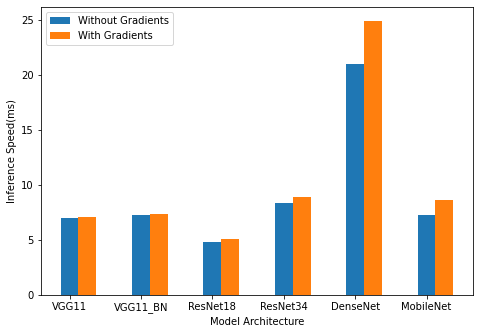

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
data = [[6.961833560466767,7.233279204368591,4.797520792484283,8.378023982048035,20.989122200012208,7.2347943663597105],[7.0927751660346985,7.314744019508362,
 5.0746567964553835,
 8.92124240398407,
 24.931730222702026,
 8.589316833019257]]


X = np.arange(6)
X_names = ['VGG11','VGG11_BN','ResNet18','ResNet34','DenseNet','MobileNet']

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0.00, data[0], width = 0.25)
ax.bar(X + 0.25, data[1], width = 0.25)
ax.set_xticks(X)
ax.set_xticklabels(X_names)
ax.set_ylabel('Inference Speed(ms)')
ax.set_xlabel('Model Architecture')

ax.legend(labels=['Without Gradients', 'With Gradients'])
plt.show()



We expect the inference speed to increase without torch.no_grad(). 

torch.no_grad() : using "with torch.no_grad()" as a loop, for every tensor within it will have requires_grad set to False. 
This disables gradient calculation. It is useful for inference when we don't want to compute gradients(no backward pass). This will be more efficient in such a scenario and reduce memory consumption and computation time.



Question 1.3

GPU Memory : 

In [49]:
# batch size = 64

# GPU memory occupied : not using torch.no_grad()


# Reference : https://huggingface.co/spaces/pytorch/vgg-nets/blame/main/app.py

def inference(input_image):
## All models in question 1.1 use the same image transformation
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    
    # Step 2 create a mini-batch as expected by the model
    #input_batch = input_tensor.unsqueeze(0) 
    #print(input_batch.shape)
    output = model(transformation(input_image))

    return output



model_list = ['vgg11','vgg11_bn','resnet18','resnet34','densenet121','mobilenet_v3_small']
memory_with_grad = []


for model_name in model_list:
  
  time = 0
  model = getattr(models, model_name)
  image_input = torch.rand(64,3,256,256)
  image_input = image_input.to(device)
  
  torch.cuda.empty_cache()
  a = torch.cuda.memory_allocated(device)

  model = model(pretrained=True).to(device)
  model.eval()

  
  output = inference(image_input)
  

  b = torch.cuda.memory_allocated(device)

  print("memory consumed by forward pass in MB",model_name,(b-a)*10**-6)
  memory_with_grad.append((b-a)*10**-6)
  model = model.to('cpu')
  torch.cuda.empty_cache()




memory consumed by forward pass in MB vgg11 3606.970368
memory consumed by forward pass in MB vgg11_bn 5508.169728
memory consumed by forward pass in MB resnet18 1424.8970239999999
memory consumed by forward pass in MB resnet34 2113.0455039999997
memory consumed by forward pass in MB densenet121 8363.820544
memory consumed by forward pass in MB mobilenet_v3_small 1063.903744


In [44]:
# batch size = 64

# GPU memory occupied : not using torch.no_grad()


# Reference : https://huggingface.co/spaces/pytorch/vgg-nets/blame/main/app.py

def inference(input_image):
## All models in question 1.1 use the same image transformation
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Step 1: Preprocess
    #input_tensor = transformation(input_image)
    #print(input_tensor.shape)

    # Step 2 create a mini-batch as expected by the model
    #input_batch = input_tensor.unsqueeze(0) 
    #print(input_batch.shape)
    
    with torch.no_grad():
      output = model(transformation(input_image))
    print("output shape:", output.shape)

    return output



model_list = ['vgg11','vgg11_bn','resnet18','resnet34','densenet121','mobilenet_v3_small']
memory_without_grad = []

torch.cuda.empty_cache()

for model_name in model_list:
  torch.cuda.empty_cache()
  time = 0
  model = getattr(models, model_name)
   
   
  image_input = torch.rand(64,3,256,256)
  image_input = image_input.to(device)

  
  a = torch.cuda.memory_allocated(device)
  model = model(pretrained=True).to(device)
  model.eval()
  output = inference(image_input)
  torch.cuda.empty_cache()
  b = torch.cuda.memory_allocated(device)
  torch.cuda.empty_cache()
  print("memory consumed in MB",model_name,(b*10**-6))
  memory_without_grad.append(b*10**-6)
  model = model.to('cpu')




output shape: torch.Size([64, 1000])
memory consumed in MB vgg11 585.867264
output shape: torch.Size([64, 1000])
memory consumed in MB vgg11_bn 582.3467519999999
output shape: torch.Size([64, 1000])
memory consumed in MB resnet18 97.655808
output shape: torch.Size([64, 1000])
memory consumed in MB resnet34 138.12838399999998
output shape: torch.Size([64, 1000])
memory consumed in MB densenet121 82.94553599999999
output shape: torch.Size([64, 1000])
memory consumed in MB mobilenet_v3_small 61.125119999999995


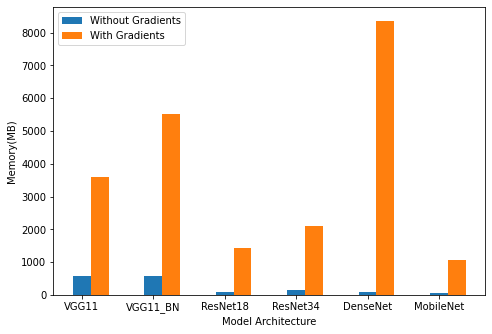

In [50]:
import numpy as np
import matplotlib.pyplot as plt


#data = [[0.256,0.256,0.256,0.256,0.256,0.256],[3123.8983, 5026.8672, 1428.154368, 2075.650048, 8331.76576, 1052.147712]]
data=[memory_without_grad,memory_with_grad]

X = np.arange(6)
X_names = ['VGG11','VGG11_BN','ResNet18','ResNet34','DenseNet','MobileNet']

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0.00, data[0], width = 0.25)
ax.bar(X + 0.25, data[1], width = 0.25)
ax.set_xticks(X)
ax.set_xticklabels(X_names)
ax.set_ylabel('Memory(MB)')
ax.set_xlabel('Model Architecture')

ax.legend(labels=['Without Gradients', 'With Gradients'])
plt.show()
